In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gluonts
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.rolling_dataset import generate_rolling_dataset, StepStrategy
from gluonts.evaluation import make_evaluation_predictions, Evaluator
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week
from PythonFiles.Configuration import Configuration
config = Configuration()
df = pd.read_csv("Influenza.csv", sep=',')

In [2]:
# Because of simplicity, only consider the first 10 locations
locations = list(df.location.unique())[:10]

# Process the df into a uniformly spaced df
one_ts_df = df.loc[df.location.isin(locations), ["value", 'location', 'date']]
one_ts_df = preprocessing(config, one_ts_df, check_count=False, output_type="corrected_df")

# seperate the intervals for training and testing
train_set_df = one_ts_df.loc[(one_ts_df.index <= config.train_end_time) &
                          (one_ts_df.index >= config.train_start_time),:]

test_set_df = one_ts_df.loc[(one_ts_df.index >= config.train_start_time) &
                         (one_ts_df.index <= config.test_end_time),:]

# Format the train and test_set into a PandasDataset
train_set = PandasDataset.from_long_dataframe(dataframe=train_set_df,
                                              item_id='location',
                                              target="value",
                                              freq=config.freq)

test_set = PandasDataset.from_long_dataframe(dataframe=test_set_df,
                                             item_id='location',
                                             target="value",
                                             freq=config.freq)

# Determine the Starting and ending time of the test_set_df
start_time = min(test_set_df.index.difference(train_set_df.index))
end_time = max(test_set_df.index.difference(train_set_df.index))
test_set = generate_rolling_dataset(dataset=test_set,
                                    strategy = StepStrategy(prediction_length=4, step_size=1),
                                    start_time = pd.Period(start_time, config.freq),
                                    end_time = pd.Period(end_time, config.freq)
                                   )

In [3]:
forecasts,tss = model(config, train_set, test_set)

100%|██████████| 50/50 [00:05<00:00,  8.82it/s, epoch=4/4, avg_epoch_loss=0.715]


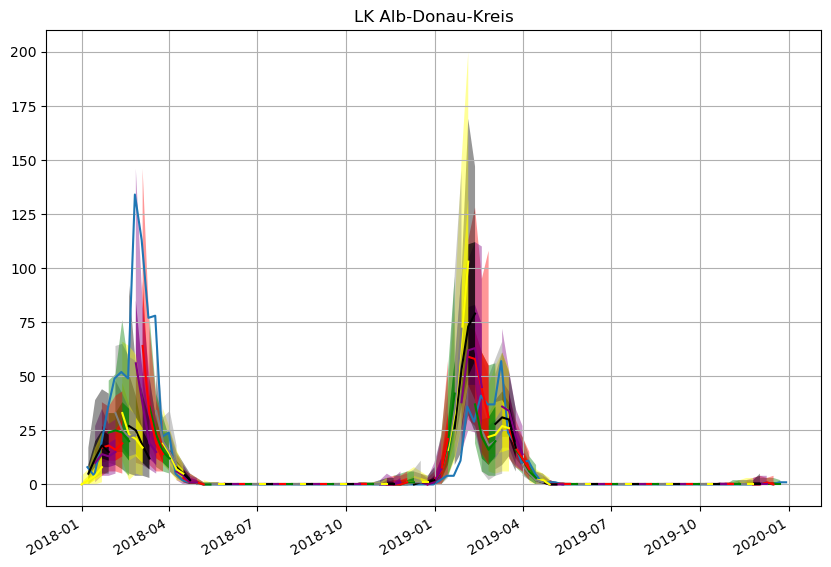

In [4]:
windows_per_location = int(len(test_set) / len(locations))
for location in locations[:1]:
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plt.title(f'{location}')
    # first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
    plt.plot((one_ts_df.loc[(one_ts_df['location'] == location) &
                            (one_ts_df.index <= config.test_end_time) &
                            (one_ts_df.index >= config.train_end_time)].index),
             one_ts_df.loc[(one_ts_df['location'] == location) &
                           (one_ts_df.index <= config.test_end_time) &
                           (one_ts_df.index >= config.train_end_time), 'value'])
    plt.grid(which="both")
    #define the colors to use for each different window
    color = ["g", "r", "purple", "black", "yellow", "grey"] * windows_per_location
    # Iterate through the correct index by changing the range with [windows_per_location]
    for k in range(0 + windows_per_location*locations.index(location),
                   windows_per_location + windows_per_location*locations.index(location)):
        forecast_entry = forecasts[k]
        prediction_intervals = (50.0, 90.0)
        forecast_entry.plot(prediction_intervals=prediction_intervals, color=color[k % windows_per_location])
    plt.grid(which="both")
    plt.show()

## Splitting the Forecasts into their week ahead composition

In [5]:
one_week_ahead_forecasts=[]
for location in locations:
    start_date_list = []
    # define the index of the time wise first forecast point
    first_time_point_of_location = windows_per_location + windows_per_location*locations.index(location)-1
    # save the array corresponding to the first week 
    weekly_samples_array = forecasts[first_time_point_of_location].samples[:,:1]
    # also append the time wise first [start_date] to [start_date_list]
    start_date_list.append(forecasts[first_time_point_of_location].start_date)
    for k in range(first_time_point_of_location - 1,
                   first_time_point_of_location - windows_per_location, -1):
        
        weekly_samples_array = np.concatenate((weekly_samples_array, forecasts[k].samples[:, :1]), axis=1)
        start_date_list.append(forecasts[k].start_date)
    
    one_week_ahead_forecasts.append(gluonts.model.forecast.SampleForecast(
        info=forecasts[first_time_point_of_location].info,
        item_id=forecasts[first_time_point_of_location].item_id,
        samples=weekly_samples_array,
        start_date=min(start_date_list)))

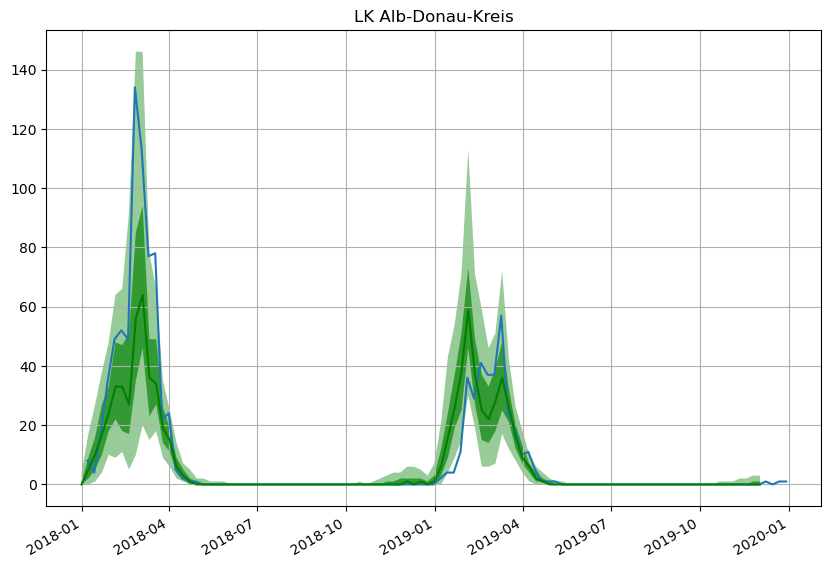

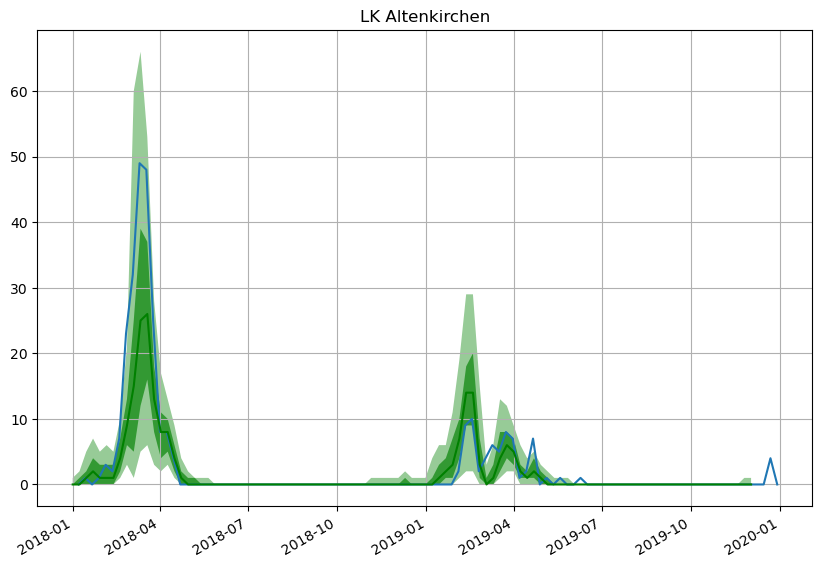

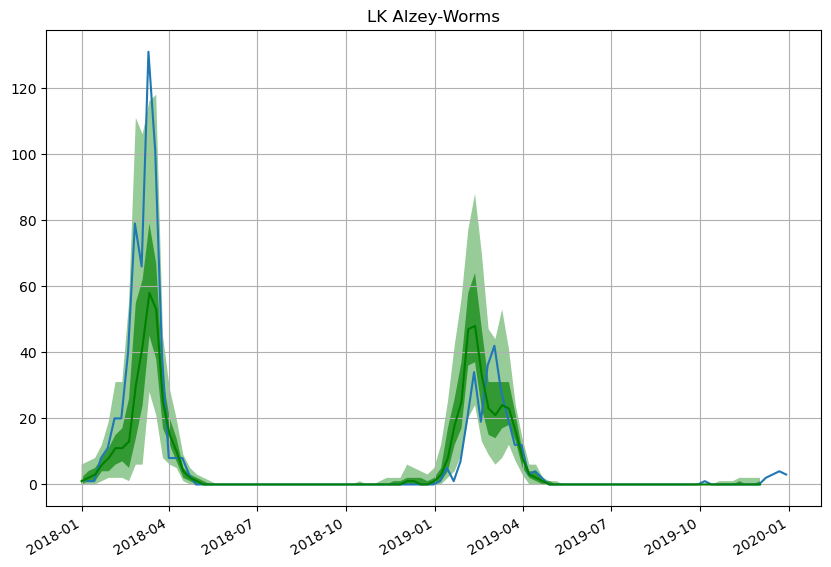

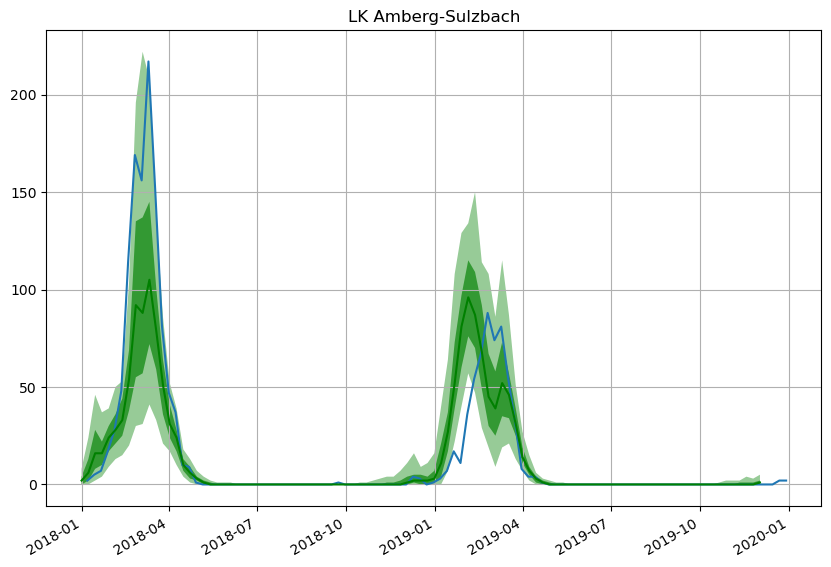

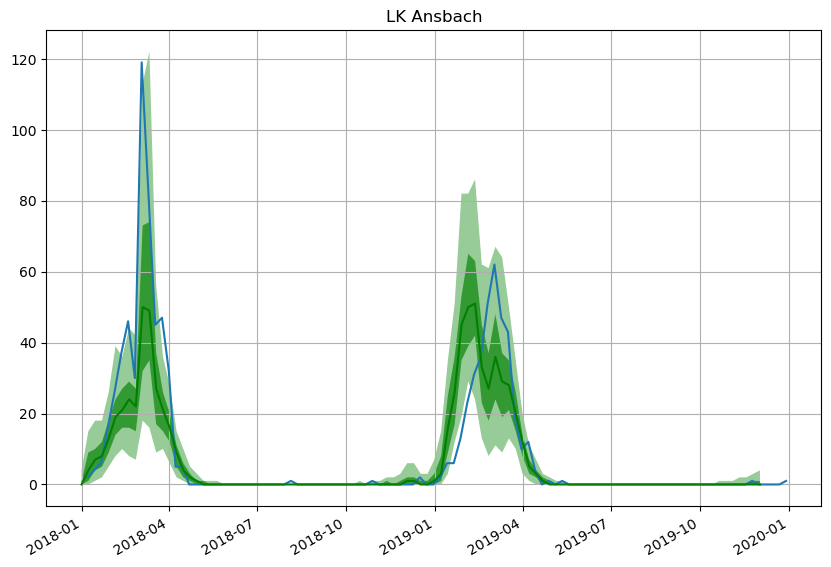

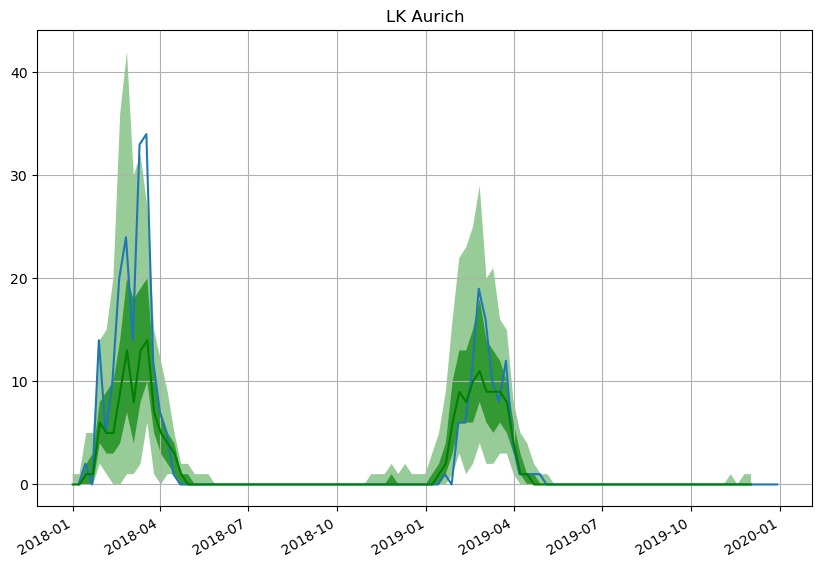

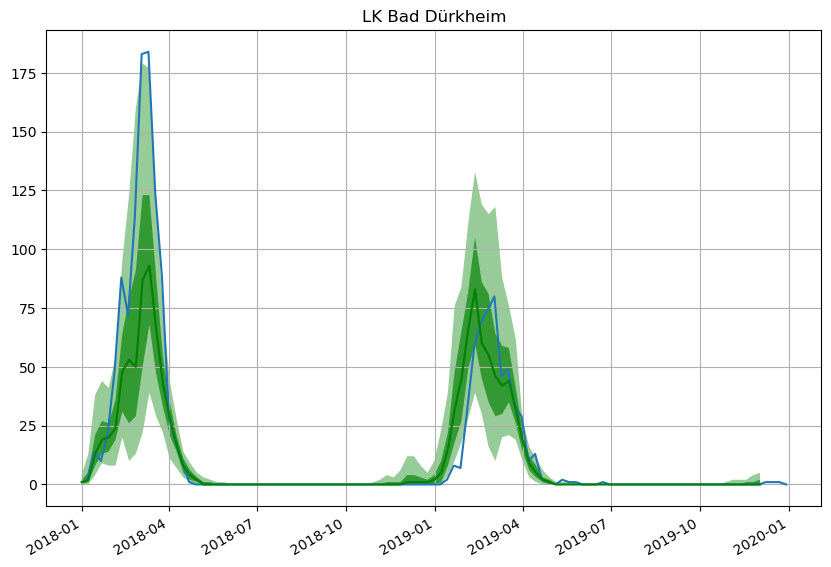

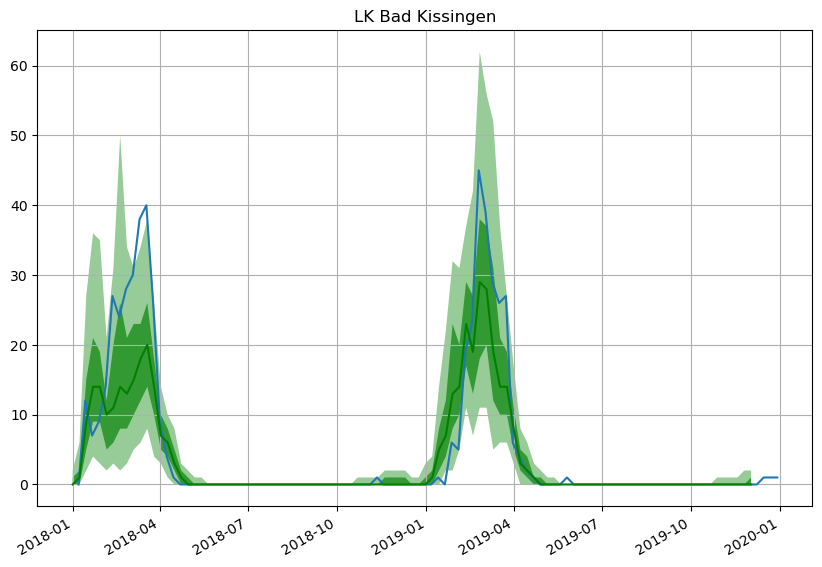

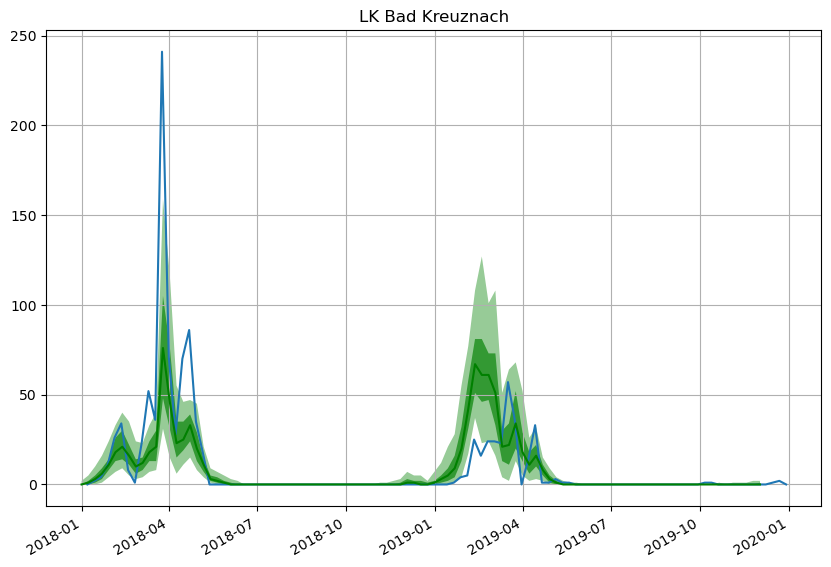

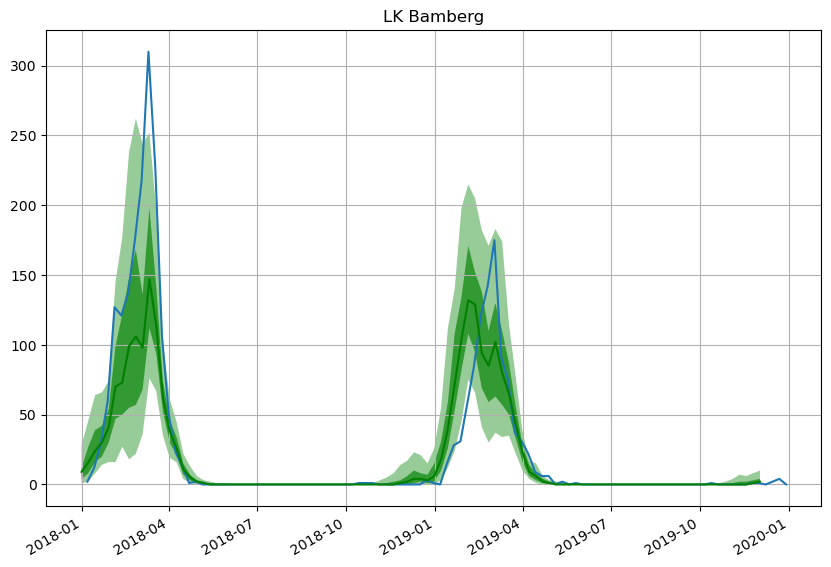

In [6]:
# PLot the Splitted Forecasts for each location
for location in locations:
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plt.title(f'{location}')
    # first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
    plt.plot((one_ts_df.loc[(one_ts_df['location'] == location) &
                            (one_ts_df.index <= config.test_end_time) &
                            (one_ts_df.index >= config.train_end_time)].index),
             one_ts_df.loc[(one_ts_df['location'] == location) &
                           (one_ts_df.index <= config.test_end_time) &
                           (one_ts_df.index >= config.train_end_time), 'value'])
    #define the colors to use for each different window
    color = ["g", "r", "purple", "black", "yellow", "grey"]
    forecast_entry = one_week_ahead_forecasts[locations.index(location)]
    prediction_intervals = (50.0, 90.0)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color=color[k % windows_per_location])
    plt.grid(which="both")
    plt.show()

### Use the Implementation within model.py

In [7]:
four_week_ahead_forecasts, split_tss = split_forecasts_by_week(config, forecasts, tss, locations, 4)

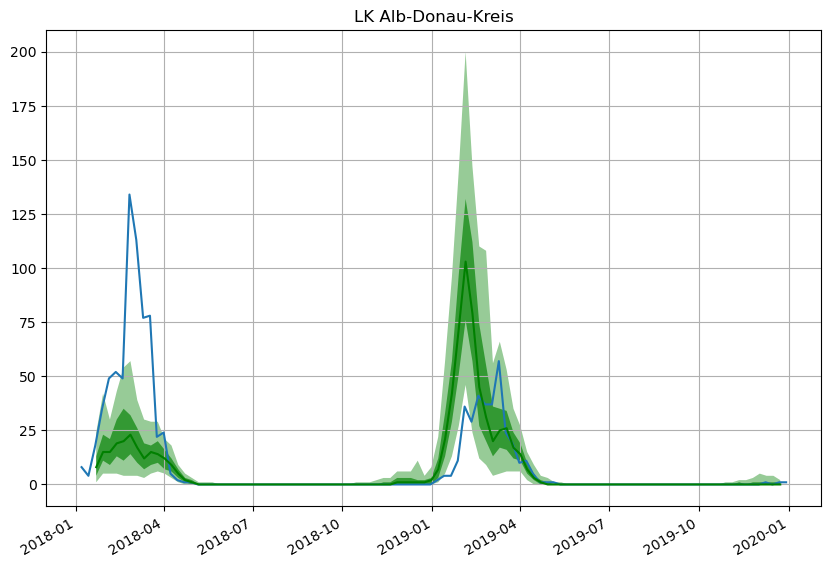

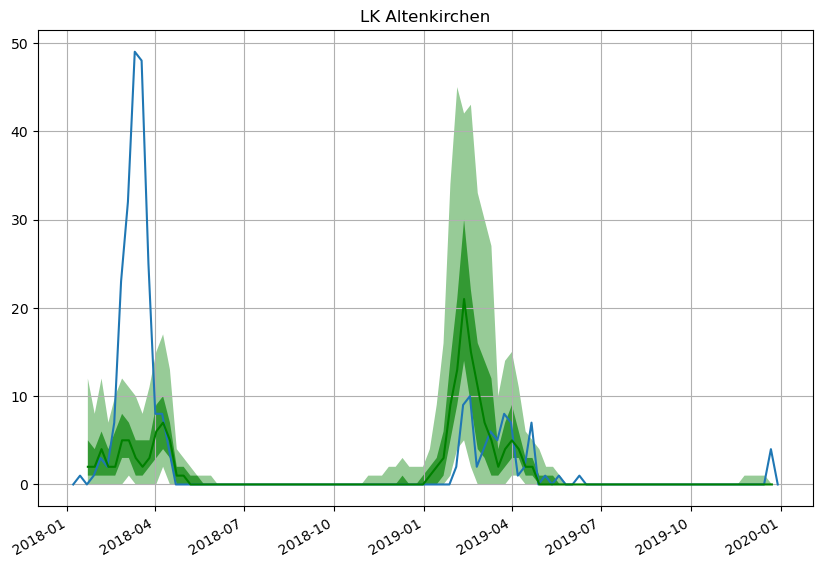

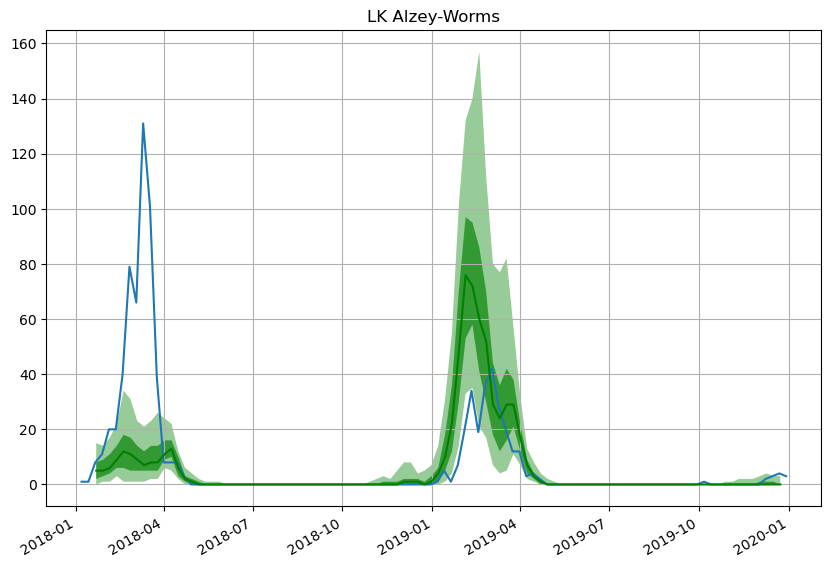

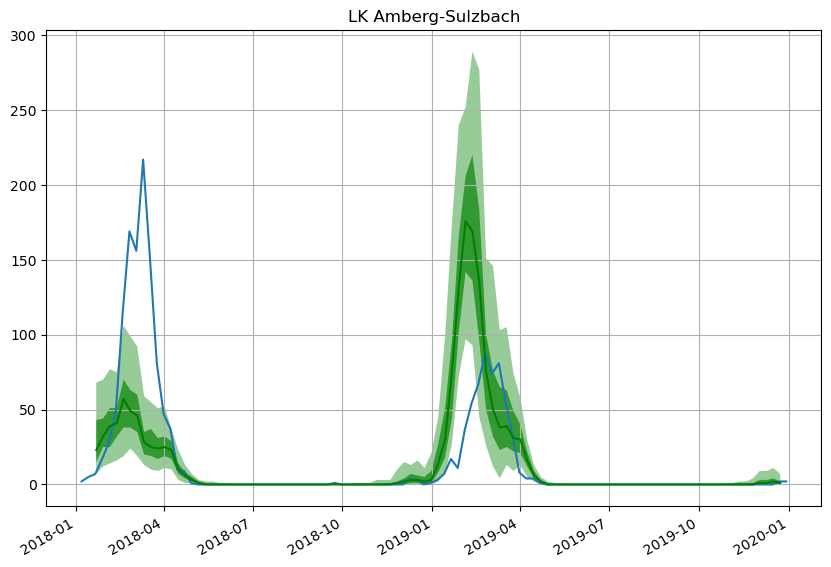

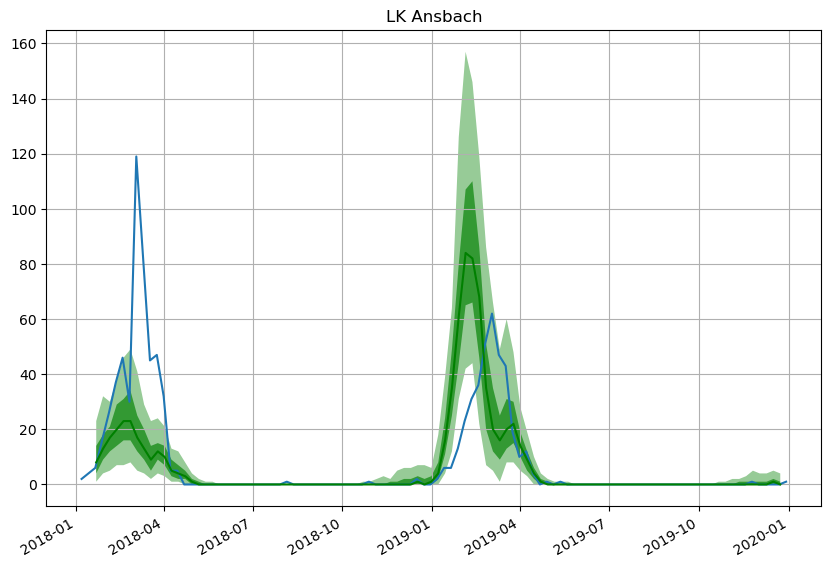

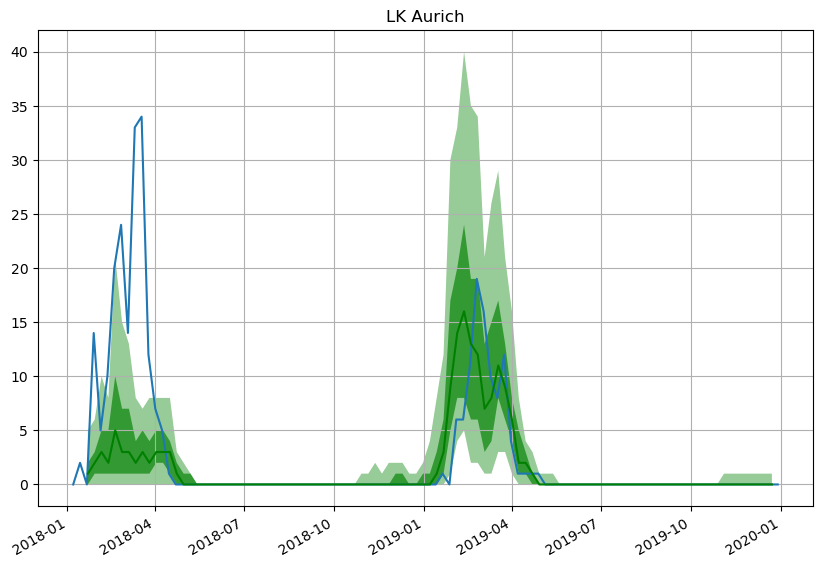

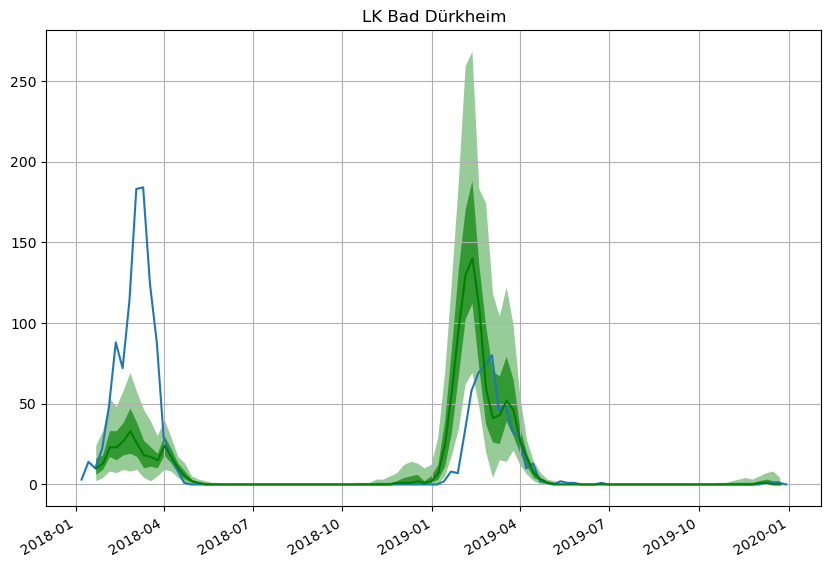

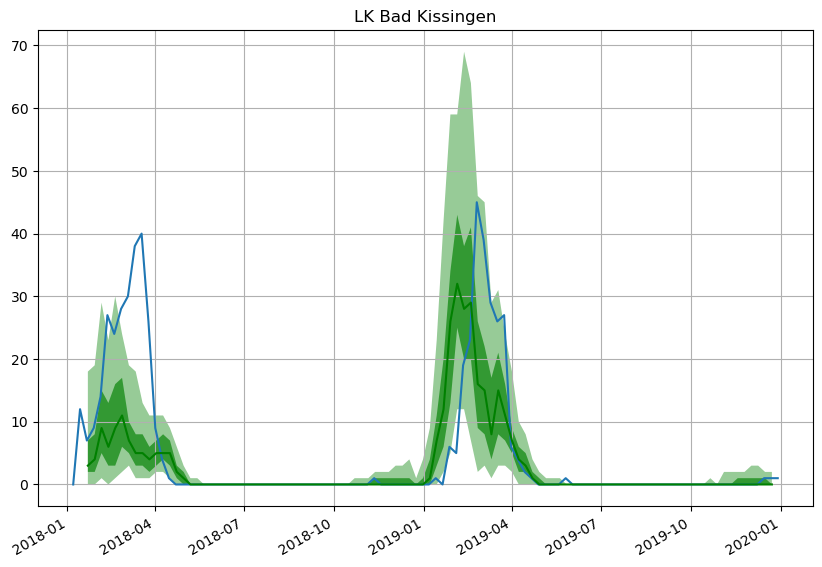

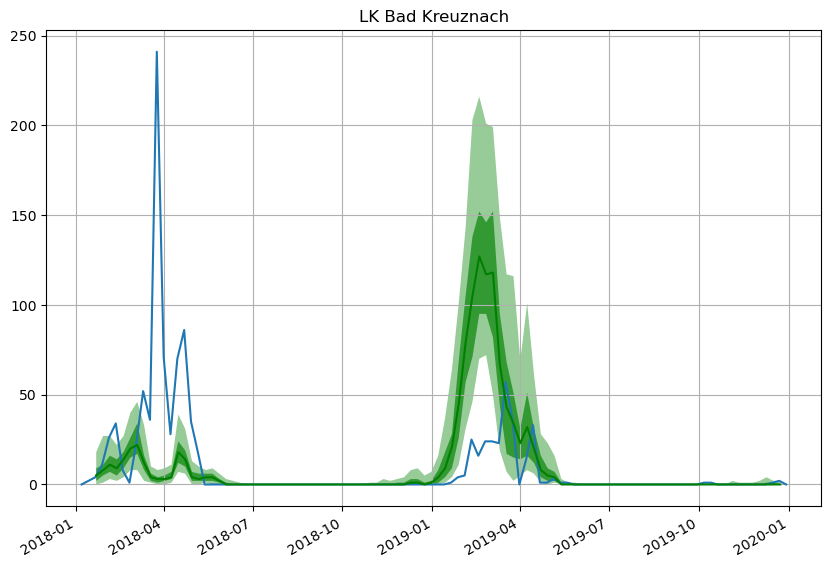

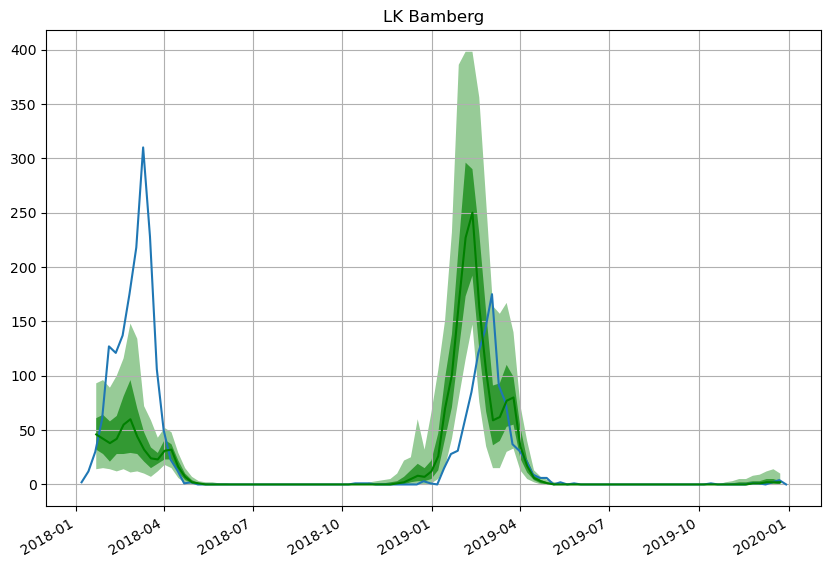

In [8]:
# PLot the Splitted Forecasts for each location
for location in locations:
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plt.title(f'{location}')
    # first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
    plt.plot((one_ts_df.loc[(one_ts_df['location'] == location) &
                            (one_ts_df.index <= config.test_end_time) &
                            (one_ts_df.index >= config.train_end_time)].index),
             one_ts_df.loc[(one_ts_df['location'] == location) &
                           (one_ts_df.index <= config.test_end_time) &
                           (one_ts_df.index >= config.train_end_time), 'value'])
    #define the colors to use for each different window
    color = ["g", "r", "purple", "black", "yellow", "grey"]
    forecast_entry = four_week_ahead_forecasts[locations.index(location)]
    prediction_intervals = (50.0, 90.0)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color=color[k % windows_per_location])
    plt.grid(which="both")
    plt.show()

In [9]:
evaluator=Evaluator(quantiles=[0.1,0.2,0.5,0.8,0.9])
agg_metrics, item_metrics = evaluator(split_tss,one_week_ahead_forecasts)
print(item_metrics)
agg_metrics, item_metrics = evaluator(split_tss,four_week_ahead_forecasts)
print(item_metrics)

Running evaluation: 10it [00:00, 14.02it/s]


              item_id         forecast_start         MSE  abs_error  \
0  LK Alb-Donau-Kreis  2018-01-01/2018-01-07  179.655670      502.0   
1     LK Altenkirchen  2018-01-01/2018-01-07   24.666557      178.0   
2      LK Alzey-Worms  2018-01-01/2018-01-07  163.969775      466.0   
3  LK Amberg-Sulzbach  2018-01-01/2018-01-07  463.075495      823.0   
4          LK Ansbach  2018-01-01/2018-01-07  151.824190      449.0   
5           LK Aurich  2018-01-01/2018-01-07   15.177525      143.0   
6     LK Bad Dürkheim  2018-01-01/2018-01-07  345.420289      685.0   
7    LK Bad Kissingen  2018-01-01/2018-01-07   29.196533      240.0   
8    LK Bad Kreuznach  2018-01-01/2018-01-07  678.860613      844.0   
9          LK Bamberg  2018-01-01/2018-01-07  899.893487     1176.0   

   abs_target_sum  abs_target_mean  seasonal_error      MASE      MAPE  \
0          1003.0         9.930693        0.992556  5.007574  0.689301   
1           277.0         2.742574        0.349876  5.037146  0.895675

Running evaluation: 10it [00:00, 19.34it/s]

              item_id         forecast_start          MSE  abs_error  \
0  LK Alb-Donau-Kreis  2018-01-22/2018-01-28   437.837485      776.0   
1     LK Altenkirchen  2018-01-22/2018-01-28    62.811804      264.0   
2      LK Alzey-Worms  2018-01-22/2018-01-28   410.164295      705.0   
3  LK Amberg-Sulzbach  2018-01-22/2018-01-28  1231.550433     1304.0   
4          LK Ansbach  2018-01-22/2018-01-28   272.508025      641.0   
5           LK Aurich  2018-01-22/2018-01-28    30.189760      200.0   
6     LK Bad Dürkheim  2018-01-22/2018-01-28  1015.203666     1205.0   
7    LK Bad Kissingen  2018-01-22/2018-01-28    56.172035      348.0   
8    LK Bad Kreuznach  2018-01-22/2018-01-28  1186.572710     1234.0   
9          LK Bamberg  2018-01-22/2018-01-28  2400.378403     1973.0   

   abs_target_sum  abs_target_mean  seasonal_error      MASE      MAPE  \
0           975.0         9.653465        1.046798  7.339685  1.080102   
1           280.0         2.772277        0.352217  7.42117